In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 9.5MB 31.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams
from sklearn.metrics import r2_score
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv     DMA_468.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_468.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [6]:
data.rename( columns={'Flow':'DMA_468','Date-time':'Date_time'}, inplace=True )

In [7]:
data_DMA468 = data[['Date_time','DMA_468']]

In [8]:
data_DMA468_indexed = data_DMA468.set_index('Date_time')

In [9]:
data_DMA468_indexed.shape

(35040, 1)

In [12]:
# Making hourly data 
hourly_data = data_DMA468_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values
data_hourly.shape

(8760, 1)

<Figure size 1584x720 with 0 Axes>

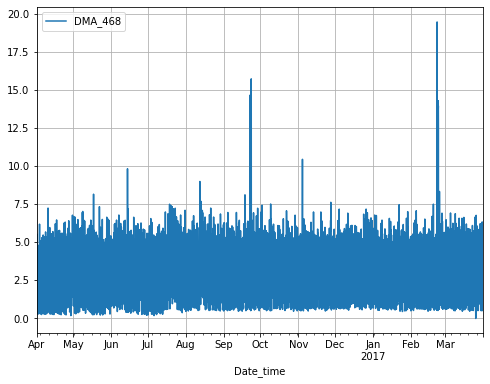

<Figure size 1584x720 with 0 Axes>

In [13]:
# Looking at plots
DMA468_df_indexed = hourly_data[['DMA_468']]
DMA468_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [14]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.137910
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -11. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value  0 < 0.05 ; Data is stationary

In [15]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.2196069417144807,
 0.1,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 0.2. The positive value is statistic, and hence we have a stationary dataset.

# Time series decomposition

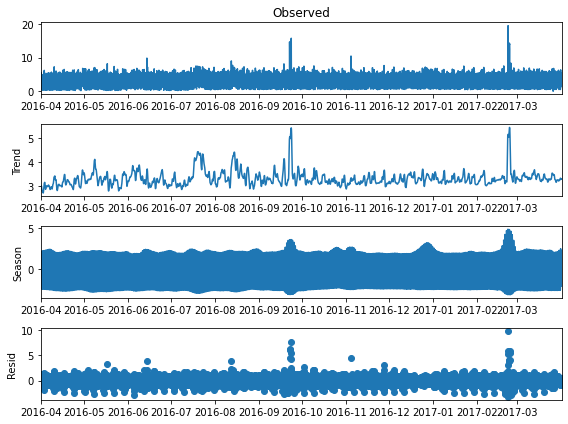

In [16]:
from statsmodels.tsa.seasonal import STL
stl = STL(hourly_data, seasonal=13)
res = stl.fit()
fig = res.plot()

# Autocorrelation and partial autocorrelation graphs

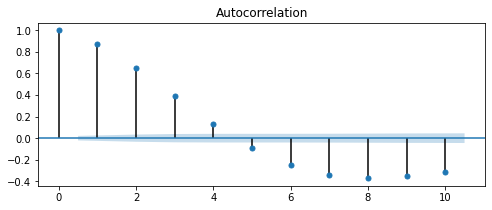

In [17]:
fig,ax = plt.subplots(figsize=(8,3))
plot_acf(hourly_data,ax=ax,lags=10)
plt.show()

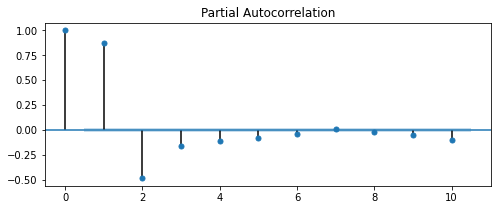

In [18]:
fig,ax = plt.subplots(figsize=(8,3))
plot_pacf(hourly_data,ax=ax,lags=10)
plt.show()

In [19]:
#Train and test split
step_in = 12
train = hourly_data[:len(hourly_data)-step_in]
test = hourly_data[len(hourly_data)-step_in:]

In [20]:
# Getting best arima model 
p = d = q = range(0, 2)
pdq_cal = list(itertools.product(p, d, q))
# generation of different combinations of seasonal p, q and q triplets
pdq_seasonal = [(x[0], x[1], x[2], step_in) for x in list(itertools.product(p, d, q))]
aic_bestvalue = np.inf
pdq_bestvalue = None
pdq_seasonal_best = None
tempmodel = None
for params in pdq_cal:   
    for seasonal_params in pdq_seasonal: 
        tempmodel = SARIMAX(train,order=params,seasonal_order = seasonal_params,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = tempmodel.fit(disp=False)
        if results.aic < aic_bestvalue:
            aic_bestvalue = results.aic
            pdq_bestvalue = params
            pdq_seasonal_best = seasonal_params
print("Best ARIMA with seasonality (SARIMAX) {} x {} model - AIC:{}".format(pdq_bestvalue,pdq_seasonal_best,aic_bestvalue))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Best ARIMA with seasonality (SARIMAX) (1, 0, 1) x (1, 1, 1, 12) model - AIC:18354.000749135204


In [21]:
#Using the best parameter in the sarimax model and do predictions
sarimaxmodel = SARIMAX(train,order=(1,0,1),seasonal_order=(1,1,1,step_in),enforce_invertibility=False,
                             enforce_stationarity=False)
sarimaxmodel_fit = sarimaxmodel.fit()
sarimax_predictions = sarimaxmodel_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [23]:
#Calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['DMA_468'], sarimax_predictions))
rmse = round(rmse, 3)
print (" The root mean square vakue on testset: ",rmse)


 The root mean square vakue on testset:  0.895


In [25]:
# Training the model on the full dataset and predict next 24 hours output
model =  SARIMAX(hourly_data['DMA_468'], 
                        order = (1, 0, 1), 
                        seasonal_order =(1, 1, 1, step_in))
output = model.fit()
  
# Forecast for the next 24 hours
step_out = 24
forecast = output.predict(start = len(hourly_data), 
                          end = (len(hourly_data)-1) + step_out, #(12*2) 
                          dynamic=False)
                          #typ = 'levels')

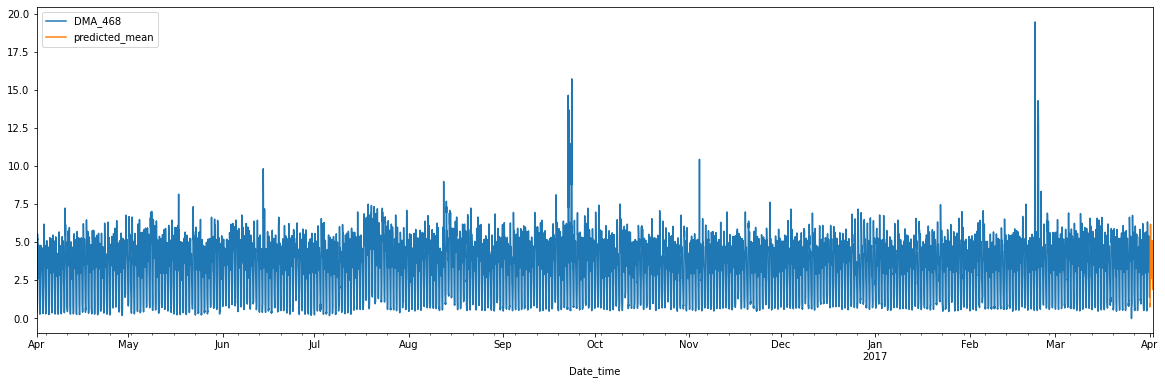

In [26]:

# Plot the forecast values
hourly_data['DMA_468'].plot(figsize = (20, 6), legend = True)
forecast.plot(legend = True)